In [1]:
#purpose is to generate images in the steps below, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to given spitzer and hubble images
2) loop through all the data, read it in, convert units
3) cutout all the data as appropriate
3) create a loop or otherwise hardcode going through all the combinations of convolutions of images by hand...
4) regrid all the images
5) de-extinct all the images
6) create apertures as appropriate for all the knots
7) perform relevant analyses: e.g. taking ratio and then finding EDFs, summing up the intensities of each knot for noting and saving
'''

#just to check python version - should be 3.7.4
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.convolution import convolve, Gaussian2DKernel, Box2DKernel
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys



3.8.13


In [2]:
# In[27]:

#setting up a new fits file to be saved and viewed in DS9
#primarily to save the image we reprojected, but can also be used to save the convolved images
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
# path = '../../Montage_results/n2071_headercut/*drz.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
# im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
# im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
# im_names_n2071 = ['../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']
# im_names_n2071 = ['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch2_synth.fits']
im_names_n2071 = ['update_pos_hops361a_160_epoch1_scaled.fits', 'update_pos_hops361a_160_epoch2_synth_scaled.fits']

print(im_names_n2071)

['update_pos_hops361a_160_epoch1_scaled.fits', 'update_pos_hops361a_160_epoch2_synth_scaled.fits']


In [4]:
hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_pix_list = []
hdu_pixtorad_list = []
# hdu_fnu_list = []
hdu_lam_list = []
# hdu_flam_list = []
# hdu_bw_list = []
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:       
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    hdu_data_list.append(np.nan_to_num(hdu_data[0].data)) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

(350.0, 990.0)

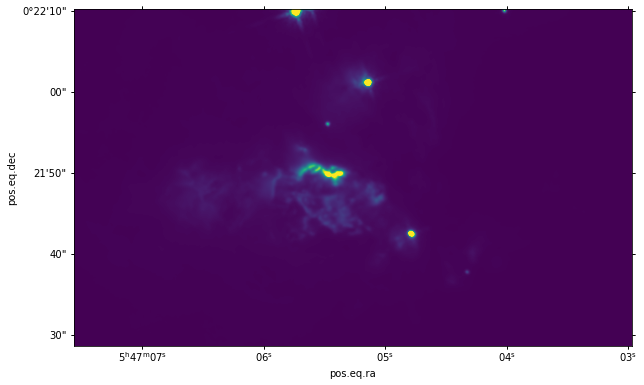

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
wcs = WCS(hdu_header_list[1])
ax = plt.subplot(projection=wcs)
ax.imshow(hdu_data_list[0], vmin=0, vmax=1)
# ax.set_xlim(475, 800 )
# ax.set_ylim(790-375, 950-375)
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 

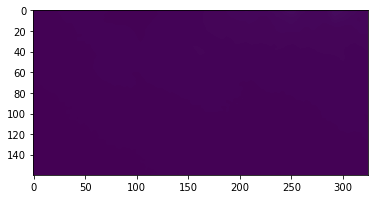

In [6]:
#here define a cutout just to derive the correct header
from astropy.nddata.utils import Cutout2D

ref_cutout = Cutout2D(hdu_data_list[0], position=(475+325/2, 415+160/2), size=(160, 325), wcs=WCS(hdu_header_list[0]))
plt.imshow(ref_cutout.data[::-1], vmin=0, vmax=1)

# Compiling aperture properties and arrows...

In [106]:
#options are cutout2D from astropy or photutils apertures (my preference)
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import EllipticalAperture, RectangularAperture

#known pixel size
hst_pixsize = 0.12825 #arcsec

#reading in the .reg files made using DS9 
# f1 = open('361A_shocked_emission_region.reg', 'r')
f1 = open('361A_shocked_emission_region_new.reg', 'r')
file1_output = []

#looping through files
for line in f1:
    file1_output.append(line)
f1.close()


#fix file contents
#contents are ra, dec, width, height, rotation
shape_list = [i.split('(')[0] for i in file1_output[3:]] #to sort by shape as needed for later
file1_output = [i.split('(')[1][:-2] for i in file1_output[3:]] #take the shape and parentheses off the list for ease of retrieving numbers

#next step is for image, loop through all regions and make a list of region properties
ra_diff_list = []
dec_diff_list = []
ra_pix_list = []
dec_pix_list = []
rad_a_list = []
rad_b_list = []
rotation_list = []

#coordinate details very much compacted (likely better ways to do this)
split_params1 = [i.split(',') for i in file1_output]
ra_hms_list = [i[0].split(':')[0]+'h' + i[0].split(':')[1]+'m' + i[0].split(':')[2]+'s' for i in split_params1]
dec_dms_list = [i[1].split(':')[0][1:]+'d' + i[1].split(':')[1]+'m' + i[1].split(':')[2]+'s'for i in split_params1]

#offsets that can be used for finding knot offsets between epochs
pos_list = [[SkyCoord(ra+' '+dec, frame=FK5, unit=(u.hourangle, u.deg))] for ra, dec in zip(ra_hms_list, dec_dms_list)] #this is all in degrees, what a lie...units are input units

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like the units? not sure
ra_pix_list = [skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[0] for i in pos_list]
dec_pix_list = [skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[1] for i in pos_list]

#aperture size details in pixels (?)
size_a_list = [1./hst_pixsize * float(rad_a1[2][:-1]) for rad_a1 in split_params1]
size_b_list = [1./hst_pixsize * float(rad_b1[3][:-1]) for rad_b1 in split_params1]
rotation_list = [round(float(rot1[4])) for rot1 in split_params1]

# #making apertures
aperture_list = []
aper_mask_list = []
for i in range(len(ra_pix_list)):
    if shape_list[i] == 'ellipse':
        aperture_list.append(EllipticalAperture([float(ra_pix_list[i]), float(dec_pix_list[i])], 
                                        2*size_a_list[i], 2*size_b_list[i], theta=rotation_list[i]*np.pi/180))
    elif shape_list[i] == 'box':
        aperture_list.append(RectangularAperture([float(ra_pix_list[i]), float(dec_pix_list[i])], 
                                        2*size_a_list[i], 2*size_b_list[i], theta=rotation_list[i]*np.pi/180))
    aper_mask_list.append(aperture_list[i].to_mask())

In [176]:
#tabulating data by hand according ot measurements and averages
speed_list = [225, 100, 80, 70, 200, 115, 135, 85, 40, 80 ,110, 50 , 150, 190]
arrow_theta = [34, 136, 90, -120, -159, -14, -140, 93, 79, 76 , 75, 112, 82, 74]

# The Horn Schunk Method
Taken from https://github.com/scivision/pyoptflow/blob/4485da929c5567470d821c3f2a23e3bccc7f768e/src/pyoptflow/hornschunck.py (should give full credits!!)

In [177]:
import numpy as np
from scipy.signal import convolve2d

HSKERN = np.array(
    [[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float
)

kernelX = np.array([[-1, 1], [-1, 1]]) * 0.25  # kernel for computing d/dx

kernelY = np.array([[-1, -1], [1, 1]]) * 0.25  # kernel for computing d/dy

kernelT = np.ones((2, 2)) * 0.25


def HornSchunck(im1, im2,
    alpha: float = 0.001,
    Niter: int = 8):
    """

    Parameters
    ----------

    im1: numpy.ndarray
        image at t=0
    im2: numpy.ndarray
        image at t=1
    alpha: float
        regularization constant
    Niter: int
        number of iteration
    """
    im1 = im1.astype(np.float32)
    im2 = im2.astype(np.float32)

    # set up initial velocities
    uInitial = np.zeros([im1.shape[0], im1.shape[1]], dtype=np.float32)
    vInitial = np.zeros([im1.shape[0], im1.shape[1]], dtype=np.float32)

    # Set initial value for the flow vectors
    U = uInitial
    V = vInitial

    # Estimate derivatives
    [fx, fy, ft] = computeDerivatives(im1, im2)

    # Iteration to reduce error
    for _ in range(Niter):
        # %% Compute local averages of the flow vectors
        uAvg = convolve2d(U, HSKERN, "same")
        vAvg = convolve2d(V, HSKERN, "same")
        # %% common part of update step
        der = (fx * uAvg + fy * vAvg + ft) / (alpha ** 2 + fx ** 2 + fy ** 2)
        # %% iterative step
        U = uAvg - fx * der
        V = vAvg - fy * der

    return U, V


def computeDerivatives(im1, im2):

    fx = convolve2d(im1, kernelX, "same") + convolve2d(im2, kernelX, "same")
    fy = convolve2d(im1, kernelY, "same") + convolve2d(im2, kernelY, "same")

    # ft = im2 - im1
    ft = convolve2d(im1, kernelT, "same") + convolve2d(im2, -kernelT, "same")

    return [fx, fy, ft]

C:\Users\arubi\AppData\Local\Temp\ipykernel_20496\3295805888.py:27: RuntimeWarning: divide by zero encountered in log
  hs_arr = HornSchunck(np.log(image0), np.log(image1), 1.5e-1, 1)
C:\Users\arubi\AppData\Local\Temp\ipykernel_20496\2641814040.py:62: RuntimeWarning: invalid value encountered in add
  fx = convolve2d(im1, kernelX, "same") + convolve2d(im2, kernelX, "same")
C:\Users\arubi\AppData\Local\Temp\ipykernel_20496\2641814040.py:63: RuntimeWarning: invalid value encountered in add
  fy = convolve2d(im1, kernelY, "same") + convolve2d(im2, kernelY, "same")
C:\Users\arubi\AppData\Local\Temp\ipykernel_20496\2641814040.py:66: RuntimeWarning: invalid value encountered in add
  ft = convolve2d(im1, kernelT, "same") + convolve2d(im2, -kernelT, "same")
C:\Users\arubi\AppData\Local\Temp\ipykernel_20496\2641814040.py:52: RuntimeWarning: invalid value encountered in multiply
  der = (fx * uAvg + fy * vAvg + ft) / (alpha ** 2 + fx ** 2 + fy ** 2)


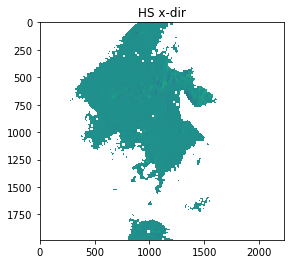

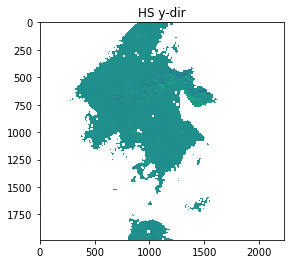

C:\Users\arubi\AppData\Local\Temp\ipykernel_20496\3295805888.py:37: RuntimeWarning: divide by zero encountered in true_divide
  flow_angles = np.arctan(hs_arr[0] / hs_arr[1]) * 180/np.pi


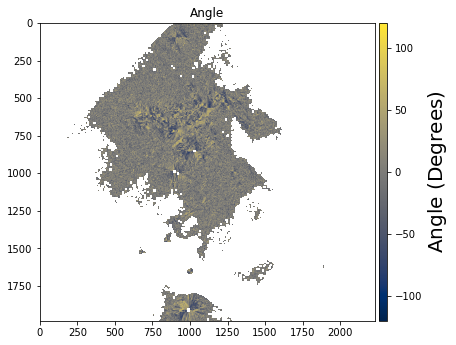

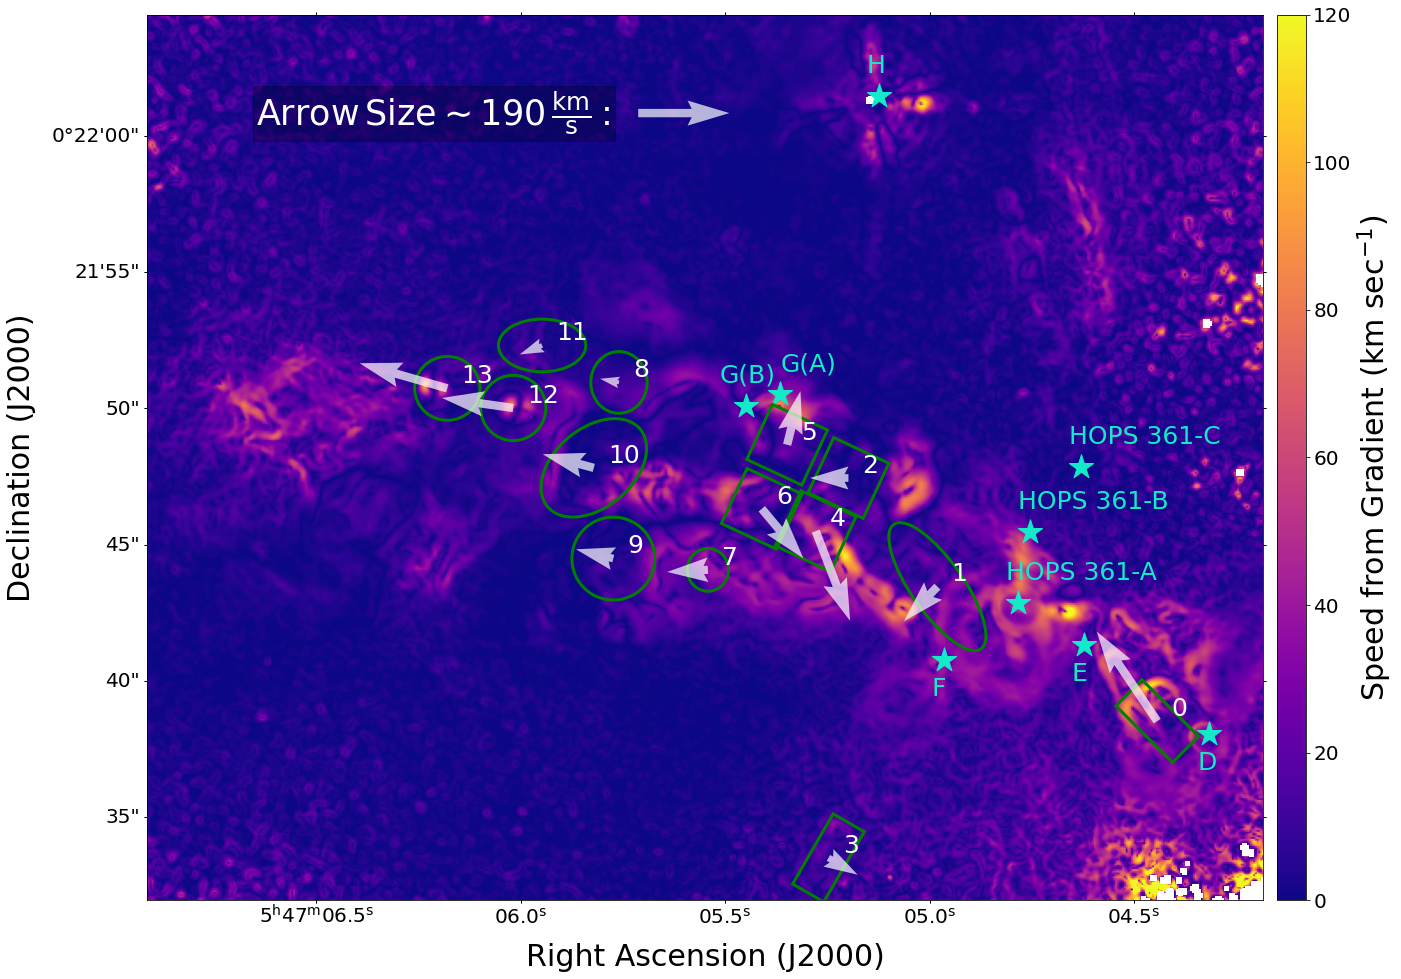

In [212]:
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel

#coordinates for IRS or HOPS objects
source_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G(A)', 'G(B)', 'H', '', ''] #HOPS 361A is IRS 1, HOPS 361B is VLA1, HOPS 361C is IRS3, HOPS 361G is IRS2, and HOPS361H is IRS4
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s',\
            '5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s', '5h47m5.819s', '05h47m4.004s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', \
            '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s', '+00d22m37.45s', '+00d22m10.38s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='fk5') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[0])))

#for hops 361-c
# hs_arr = HornSchunck(np.flip(1e5*hdu_data_list[0] - binary_epoch1, axis=1),
#                      np.flip( 1e5*hdu_data_list[1] - binary_epoch2, axis=1))

#for hops 361-a
#cutting out images by hand to make sure they're correct
# image0 = hdu_data_list[0][::-1][790:950, 475:800]
# image1 = hdu_data_list[1][::-1][790:950, 475:800]
image0 = hdu_data_list[0] #[350:990, 470:1530] #define images...
image1 = hdu_data_list[1] #[350:990, 470:1530]
# hs_arr = HornSchunck(np.flip(hdu_data_list[0], axis=0), np.flip( hdu_data_list[1], axis=0))
hs_arr = HornSchunck(np.log(image0), np.log(image1), 1.5e-1, 1)

plt.title('HS x-dir')
plt.imshow(hs_arr[0], vmin=-1e1, vmax=1e1) #x-direction
plt.show()
plt.title('HS y-dir')
plt.imshow(hs_arr[1], vmin=-1e1, vmax=1e1) #y-direction
plt.show()

#angle
flow_angles = np.arctan(hs_arr[0] / hs_arr[1]) * 180/np.pi

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(flow_angles, vmin=-120, vmax=120, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
plt.show()

#magnitude calculation and constants
n2071_dist = 1.32808e16  #430.6 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #11 yrs to secs
# interesting_flow = np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.) *pix_size* n2071_dist/206265 / time #* np.max( np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.)) \
interesting_flow = pix_size* n2071_dist/206265 / time  * np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.) # * 500 / np.max( np.sqrt(hs_arr[1]**2. + hs_arr[0]**2.))

#plotting the speed map
fig, ax = plt.subplots(figsize=(20,20))

#first set up the WCS and plot data
wcs = WCS(hdu_header_list[1])
ax = plt.subplot(projection=wcs)
# im1 = ax.imshow(hdu_data_list[0], vmin=0, vmax=1, alpha=0)
# ax.set_title('Magnitude')
im2 = ax.imshow(interesting_flow, vmin=0, vmax=120, cmap='plasma') #, alpha=1, extent=(475, 800, 575, 415)) #plot data
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='xkcd:aqua', marker='*', s=650) for c_pair in coord_pix_list]
for c_pair in range(len(coord_pix_list)):
    if source_names[c_pair] != 'E' and source_names[c_pair] != 'F' and source_names[c_pair] != 'D':
        y_offset = 13
    else:
        y_offset = -20

    if source_names[c_pair] != 'G(A)' and source_names[c_pair] != 'G(B)':
        x_offset = -7
    elif source_names[c_pair] == 'G(A)':
        x_offset = 0
    elif source_names[c_pair] == 'G(B)':    
        x_offset = -15

    if source_names[c_pair] != 'A' and source_names[c_pair] != 'B' and source_names[c_pair] != 'C':
        ax.annotate(source_names[c_pair], (coord_pix_list[c_pair][0]+x_offset, coord_pix_list[c_pair][1]+y_offset), color='xkcd:aqua', fontsize=25)
    else:
        ax.annotate('HOPS 361-' + source_names[c_pair], (coord_pix_list[c_pair][0]-7, coord_pix_list[c_pair][1]+y_offset), color='xkcd:aqua', fontsize=25)

#plot the apertures for our different knots
for aperture_ind in range(len(aperture_list)):
    aperture = aperture_list[aperture_ind]
    aperture.plot(ax, linewidth=3, edgecolor='green')
    ax.annotate(str(aperture_ind), (aperture.positions[0]+8, aperture.positions[1]+3), fontsize=25, color='white') #comment this or adjust if you want numbers


#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
from matplotlib.lines import Line2D
line_list = []
for ind in range(len(ra_pix_list)):
    #region params
    x_pix = ra_pix_list[ind]
    y_pix = dec_pix_list[ind]

    #arrow pos params
    x_origin = float(x_pix) #+width_pix/2. #-self_brightest_list[ind][1]
    y_origin = float(y_pix)  #+height_pix/2. #-self_brightest_list[ind][0]

    #compute position angle
    if arrow_theta[ind] < 0:
        theta_calc = (90+arrow_theta[ind])*np.pi/180
    else:
        theta_calc = (arrow_theta[ind] + 90)*np.pi/180

    #arrow speed params
    vx = speed_list[ind] * np.cos(theta_calc)
    vy = speed_list[ind] * np.sin(theta_calc)

    #plotting arrows
    Q = ax.quiver(x_origin, y_origin, vx, vy, \
             color='white', scale_units='inches', angles='uv', units='inches', scale=150, \
             alpha = 0.7)#, facecolor='hotpink', edgecolor='fuchsia')
    #violet or gray may also be possible colors

#legends, needs to be done before angles or else...BAD! THINGS!
# ax.coords.grid(True, color='black', ls='--', linewidth=0.25) #adding gridlines, needs to be done before making the arrow
# diff_data.shape[0], diff_data.shape[1]
qk = ax.quiverkey(Q, coord_pix_list[2:3][0][0]-250, coord_pix_list[2:3][0][1]+200, speed_list[ind], \
                  label=r'$\rm Arrow \, Size \sim 190 \, \frac{km}{s}:$', labelcolor='white', \
                  labelpos='W', labelsep=0.375, coordinates='data', angle=0, fontproperties={'size':35}, alpha=0.7)
t = qk.text.set_bbox(dict(facecolor='black', alpha=0.25))
# ax.quiver(0, 0, -2, 0, color='fuchsia', label='Arrow Scale: 44 km/s', scale_units='xy', angles='xy', units='xy')
# ax.scatter(0, 0, color='fuchsia', marker='*', s=500, label='HOPS 361-C')
# ax.legend(loc='lower left', fontsize=40)


#formatting the axes of the speed map
ax.set_xlim(620, 1250) # ax.set_xlim(475, 800 )
ax.set_ylim(400, 900) # ax.set_ylim(790-375, 950-375) 
ax.coords[0].set_minor_frequency(1) #for minor ticks
ax.coords[1].set_minor_frequency(1)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=20)
ax.tick_params(axis='y', which='minor', length=20)
ax.set_ylabel('Declination (J2000)', fontsize=30)
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)

#set up a color bar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height]) 
cbar = plt.colorbar(im2, cax=cax)
cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Speed\ from\ Gradient~(km \ sec^{-1})$', size=30)
plt.show()

fig.savefig('361a_mag_speed.pdf', dpi=300, bbox_inches="tight")

In [11]:
interesting_flow.shape[0]

1982

In [10]:
im1.get_extent()

NameError: name 'im1' is not defined

In [12]:
ref_cutout.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 86.76989472222222  0.3695373103646667  
CRPIX : 639.788726376634  576.4713893880687  
CD1_1 CD1_2  : -1.8055554893281e-05  2.69196603096121e-19  
CD2_1 CD2_2  : -2.9227635277624e-22  1.80555548932811e-05  
NAXIS : 325  160

In [13]:
hdu_header_list[0]

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2229                                                  
NAXIS2  =                 1982                                                  
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'SCI     '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'ib0la0paq                         ' / rootname of the observation set
EXPNAME = 'ib0la0paq                ' / exposure identifier                     
BUNIT   = 'ELECTRONS/S'        / brightness units                               
                                                                                
              / World Coordi

In [14]:
from astropy.coordinates import SkyCoord, FK5, ICRS

#need to edit header to the appropriate reference point since we've cropped the image...note AXIS1 is y, while AXIS2 is x
flow_map_header = hdu_header_list[0]
# flow_map_header['CRPIX1'] = 160
# flow_map_header['CRPIX2'] = 0

#save images
fits_saver(interesting_flow, flow_map_header, '361a_HS_mag_speed.fits', '')
fits_saver(flow_angles, flow_map_header, '361a_HS_angles.fits', '')

'361a_HS_angles.fits'

# Attempting Lucas-Kanade

In [41]:
#all credits for this code goes to this wordpress site by "Sandipan Dey"=https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/
#please visit!

import numpy as np
from scipy import signal
def LucaseKanade(I1g, I2g, window_size, tau=1e-2):
 
    kernel_x = np.array([[-1., 1.], [-1., 1.]])
    kernel_y = np.array([[-1., -1.], [1., 1.]])
    kernel_t = np.array([[1., 1.], [1., 1.]])#*.25
    w = int(window_size/2) # window_size is odd, all the pixels with offset in between [-w, w] are inside the window
    I1g = I1g # normalize pixels
    I2g = I2g # normalize pixels
    # Implement Lucas Kanade
    # for each point, calculate I_x, I_y, I_t
    mode = 'same'
    fx = signal.convolve2d(I1g, kernel_x, boundary='symm', mode=mode)
    fy = signal.convolve2d(I1g, kernel_y, boundary='symm', mode=mode)
    ft = signal.convolve2d(I2g, kernel_t, boundary='symm', mode=mode) + \
         signal.convolve2d(I1g, -kernel_t, boundary='symm', mode=mode)
    u = np.zeros(I1g.shape)
    v = np.zeros(I1g.shape)
    # within window window_size * window_size
    for i in range(w, I1g.shape[0]-w):
        for j in range(w, I1g.shape[1]-w):
            Ix = fx[i-w:i+w+1, j-w:j+w+1].flatten()
            Iy = fy[i-w:i+w+1, j-w:j+w+1].flatten()
            It = ft[i-w:i+w+1, j-w:j+w+1].flatten()
            b = np.reshape(It, (It.shape[0],1)) # get b here
            A = np.vstack((Ix, Iy)).T # get A here
            # if threshold Ï„ is larger than the smallest eigenvalue of A'A:
            if np.min(abs(np.linalg.eigvals(np.matmul(A.T, A)))) >= tau:
                nu = np.matmul(np.linalg.pinv(A), b) # get velocity here
                u[i,j]=nu[0]
                v[i,j]=nu[1]
 
    return (u,v)

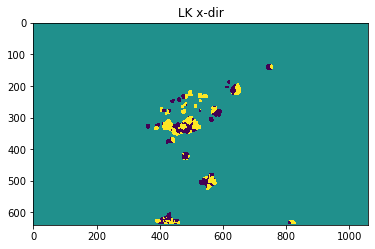

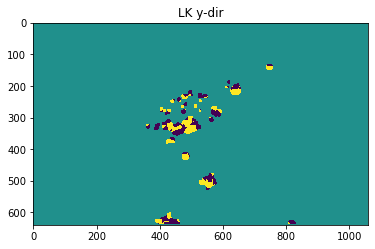

C:\Users\arubi\AppData\Local\Temp\ipykernel_29808\4290019256.py:16: RuntimeWarning: invalid value encountered in true_divide
  flow_angles = np.arctan(lk_arr[1] / lk_arr[0]) * 180/np.pi


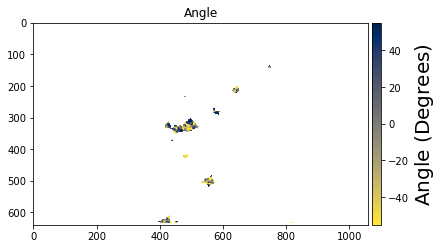

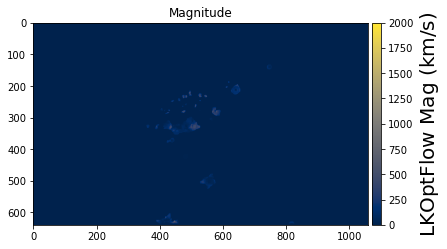

In [44]:
image0 = hdu_data_list[0][350:990, 470:1530]
image1 = hdu_data_list[1][350:990, 470:1530]

# lk_arr = LucaseKanade(np.flip(hdu_data_list[0] - bkg_list[0].background - binary_adaptive1, axis=1),
#                      np.flip( hdu_data_list[1] - bkg_list[1].background - binary_adaptive2, axis=1), 10, 1e-1)
lk_arr = LucaseKanade(image0, image1, 10, 1e-2)

plt.title('LK x-dir')
plt.imshow(lk_arr[0], vmin=-1e-16, vmax=1e-16) #x-direction
plt.show()
plt.title('LK y-dir')
plt.imshow(lk_arr[1], vmin=-1e-16, vmax=1e-16) #y-direction
plt.show()

#angle
flow_angles = np.arctan(lk_arr[1] / lk_arr[0]) * 180/np.pi

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(flow_angles, vmin=-55, vmax=55, cmap='cividis_r')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Angle~(Degrees)$', size=20)
ax.set_title('Angle')
plt.show()

#magnitude
n2071_dist = 1.32808e16  #430.6 pc to km
pix_size = 0.12825 #for hst
time = 3.471e+8 #11 yrs to secs
interesting_flow = np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.) *pix_size* n2071_dist/206265 / time #* np.max( np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.)) \

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Magnitude')              
im = ax.imshow((interesting_flow), vmin=0, vmax=2000, cmap='cividis')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax)
# cbar.ax.tick_params(labelsize=20)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm LKOptFlow~Mag~(km/s)$', size=20)
plt.show()

In [28]:
np.mean(np.sqrt(lk_arr[1]**2. + lk_arr[0]**2.) *pix_size* n2071_dist/206265 / time)

86.87141319280457

In [29]:
pix_size* n2071_dist/206265 / time

23.790384192692013

In [25]:
fits_saver(np.flip(interesting_flow, axis=0), hdu_header_list[0], '361a_LK_mag_speed.fits', '')
fits_saver(np.flip(flow_angles, axis=0), hdu_header_list[0], '361a_LK_angles.fits', '')

'361a_LK_angles.fits'